In [277]:
import sys
sys.path.append('../experiments')

In [2]:
%load_ext autoreload
%autoreload 2

In [109]:
import utils
import joblib
import pandas as pd
from run_experiment import run_experiment
import pmsurv_exponential 
import pmsurv_weibull
import pmsurv_weibull_nn
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from pmsurv.models.exponential_model import ExponentialModel
from pmsurv.models.weibull_linear import WeibullModelLinear
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pmsurv

In [140]:
SEED = 42

In [141]:
dataset, config = utils.load_data('../experiments/data/veteran')
train_kwargs = {'jobs': 5, 'n_iter': 10}
# continuous_features = config['preprocessing']['continuous_features']

In [149]:
dataset['celltype_1:trt'] = dataset['celltype_1'] * dataset['trt_2']
dataset['celltype_2:trt'] = dataset['celltype_2'] * dataset['trt_2']
dataset['celltype_3:trt'] = dataset['celltype_3'] * dataset['trt_2']
dataset['celltype_4:trt'] = dataset['celltype_4'] * dataset['trt_2']

config['features'] = ['age', 'trt_2', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
config['preprocessing']['standardize'] = True
config['preprocessing']['continuous_features'] = ['age']

In [150]:
dataset

,age,karno,diagtime,prior_10,trt_2,celltype_1,celltype_2,celltype_3,celltype_4,time,status,celltype_1:trt,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,69,60,7,0.0,0.0,1.0,0.0,0.0,0.0,72,1,0.0,0.0,0.0,0.0
1,64,70,5,1.0,0.0,1.0,0.0,0.0,0.0,411,1,0.0,0.0,0.0,0.0
2,38,60,3,0.0,0.0,1.0,0.0,0.0,0.0,228,1,0.0,0.0,0.0,0.0
3,63,60,9,1.0,0.0,1.0,0.0,0.0,0.0,126,1,0.0,0.0,0.0,0.0
4,65,70,11,1.0,0.0,1.0,0.0,0.0,0.0,118,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,65,75,1,0.0,1.0,0.0,0.0,0.0,1.0,133,1,0.0,0.0,0.0,1.0
133,64,60,5,0.0,1.0,0.0,0.0,0.0,1.0,111,1,0.0,0.0,0.0,1.0
134,67,70,18,1.0,1.0,0.0,0.0,0.0,1.0,231,1,0.0,0.0,0.0,1.0
135,65,80,4,0.0,1.0,0.0,0.0,0.0,1.0,378,1,0.0,0.0,0.0,1.0


In [151]:
X_predict_original = pd.DataFrame({
    'age': [50, 50, 65, 65],
    # 'diagtime': [5, 5, 5, 5],
    'trt_2': [0, 0, 1, 0],
    # 'prior_10': [0, 0, 0, 0],
    # 'celltype_1': [1, 1, 0, 0], 
    'celltype_2': [0, 0, 1, 1], 
    'celltype_3': [1, 1, 0, 0], 
    'celltype_4': [0, 0, 0, 0], 
    'celltype_2:trt': [0, 0, 1, 0], 
    'celltype_3:trt': [1, 0, 0, 0],  
    'celltype_4:trt': [0, 0, 0, 0],
    # 'karno': [80, 80, 80, 80]
})
# X_predict_original = dataset[config['features']]
X_predict_original

,age,trt_2,celltype_2,celltype_3,celltype_4,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,50,0,0,1,0,0,1,0
1,50,0,0,1,0,0,0,0
2,65,1,1,0,0,1,0,0
3,65,0,1,0,0,0,0,0


In [12]:
def train_model_generic(dataset, config, train_kwargs, preprocess_data_fun, train_fun):
    dataset = dataset.dropna(subset=config['features'])
    X, y = preprocess_data_fun(dataset, config)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=config['split']['test_size'],
                                                        shuffle=config['split']['shuffle'])

    if config['preprocessing']['standardize']:
        X_train, X_test, scaler = utils.standardize(X_train, X_test, config)
    else:
        scaler = None

    pipeline, parameters, fit_params = train_fun(X_train, y_train, config, train_kwargs)
    n_cv = 5
    n_points = int(train_kwargs['jobs'] / n_cv)
    opt = BayesSearchCV(pipeline, parameters,
                        fit_params=fit_params,
                        n_jobs=train_kwargs['jobs'],
                        n_points=n_points if n_points > 1 else 1,
                        n_iter=train_kwargs['n_iter'],
                        cv=n_cv,
                        error_score='raise')
    opt.fit(X_train, y_train)
    metrics = opt.best_estimator_.score(X_test, y_test)
    print("Test metrics: " + str(metrics))

    return metrics, opt.best_estimator_, opt.best_params_, scaler, (X_train, X_test, y_train, y_test)

# Exponential

In [152]:
metrics, model_e, best_params_e, scaler_e, data_e = train_model_generic(dataset, config, train_kwargs, pmsurv_exponential.preprocess_data, pmsurv_exponential.train_model)

/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")
/usr/local/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.222073
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.296374
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]WARNING:jax._src.lib.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.111978
Sampling...
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.580315
Sampling...
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.440230
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:06<00:00, 466.04it/s]  

Running chain 0: 100%|██████████| 3000/3000 [00:06<00:00, 460.06it/s]  
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Running chain 1: 100%|██████████| 3000/3000 [00:06<00:00, 470.59it/s]  

Running chain 1: 100%|██████████| 3000/3000 [00:07<00:00, 424.12it/s]  
Sampling: [y]
INFO:pymc:Sampling: [y]
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: [y

Sampling time =  0:00:07.599055
Transforming variables...
Transformation time =  0:00:00.449706
Computing Log Likelihood...
Log Likelihood time =  0:00:00.841985
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.233292
Sampling...
Sampling time =  0:00:06.877784
Transforming variables...
Transformation time =  0:00:00.355474
Computing Log Likelihood...
Log Likelihood time =  0:00:00.856097
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.477676
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:07.192198
Transforming variables...
Transformation time =  0:00:00.327906
Computing Log Likelihood...
Log Likelihood time =  0:00:00.942221
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.492960
Sampling...
Sampling time =  0:00:06.870194
Transforming variables...
Transformation time =  0:00:00.348467
Computing Log Likelihood...
Log Likelihood time =  0:00:00.944510
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.614929
Sampling...
Sampling time =  0:00:06.930381
Transforming variables...
Transformation time =  0:00:00.293755
Computing Log Likelihood...
Log Likelihood time =  0:00:00.877755
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferenceda

Running chain 1: 100%|██████████| 3000/3000 [00:06<00:00, 474.63it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:06<00:00, 484.20it/s]  
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: [y]
INFO:pymc:Sampling: [y]
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive samplin

Sampling time =  0:00:06.480185
Transforming variables...
Transformation time =  0:00:00.262812
Computing Log Likelihood...
Log Likelihood time =  0:00:00.366095
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.132068
Sampling...
Sampling time =  0:00:06.586291
Transforming variables...
Transformation time =  0:00:00.165952
Computing Log Likelihood...
Log Likelihood time =  0:00:00.261212
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.324223
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:06.591596
Transforming variables...
Transformation time =  0:00:00.176129
Computing Log Likelihood...
Log Likelihood time =  0:00:00.386135
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.294071
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:06.496969
Transforming variables...
Transformation time =  0:00:00.289402
Computing Log Likelihood...
Log Likelihood time =  0:00:00.599251
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.678293
Sampling...
Sampling time =  0:00:06.438901
Transforming variables...
Transformation time =  0:00:00.244725
Computing Log Likelihood...
Log Likelihood time =  0:00:00.790711
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.602770
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 249.34it/s] 
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: [y]
INFO:pymc:Sampling: [y]
Sampling: [y]
INFO:pymc:Sampling: [y]
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to inval

Sampling time =  0:00:11.232947
Transforming variables...
Transformation time =  0:00:00.758757
Computing Log Likelihood...
Log Likelihood time =  0:00:01.005742
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.852597
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.501307
Transforming variables...
Transformation time =  0:00:00.609012
Computing Log Likelihood...
Log Likelihood time =  0:00:02.052592
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.288929
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.275697
Transforming variables...
Transformation time =  0:00:00.604738
Computing Log Likelihood...
Log Likelihood time =  0:00:01.783746
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.437243
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.394074
Transforming variables...
Transformation time =  0:00:00.499785
Computing Log Likelihood...
Log Likelihood time =  0:00:00.771031
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.139139
Sampling...
Sampling time =  0:00:12.277700
Transforming variables...
Transformation time =  0:00:00.400267
Computing Log Likelihood...
Log Likelihood time =  0:00:01.366938
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.281306
Sampling...


Running chain 0: 100%|██████████| 3000/3000 [00:11<00:00, 265.69it/s]  

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 241.64it/s]  
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: [y]
INFO:pymc:Sampling: [y]
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampl

Sampling time =  0:00:13.495774
Transforming variables...
Transformation time =  0:00:00.334635
Computing Log Likelihood...
Log Likelihood time =  0:00:00.501818
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.325849
Sampling...
Sampling time =  0:00:11.936604
Transforming variables...
Transformation time =  0:00:00.220683
Computing Log Likelihood...
Log Likelihood time =  0:00:00.701990
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.782415
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.996376
Transforming variables...
Transformation time =  0:00:00.338732
Computing Log Likelihood...
Log Likelihood time =  0:00:00.588412
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.531863
Sampling...
Sampling time =  0:00:12.529930
Transforming variables...
Transformation time =  0:00:00.235871
Computing Log Likelihood...
Log Likelihood time =  0:00:00.608729
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.079890
Sampling...
Sampling time =  0:00:13.571792
Transforming variables...
Transformation time =  0:00:00.231217
Computing Log Likelihood...
Log Likelihood time =  0:00:00.577633
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferenceda

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 331.24it/s]  

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 308.84it/s]  

Running chain 1:   0%|          | 0/3000 [00:10<?, ?it/s]/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 289.03it/s]  
Sampling: [y]
INFO:pymc:Sampling: [y]
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: [y]
INFO:pymc:Sa

Sampling time =  0:00:10.274830
Transforming variables...
Transformation time =  0:00:00.232357
Computing Log Likelihood...
Log Likelihood time =  0:00:00.956000
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.135316
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.819860
Transforming variables...
Transformation time =  0:00:00.218234
Computing Log Likelihood...
Log Likelihood time =  0:00:01.201829
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.816061
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.331350
Transforming variables...
Transformation time =  0:00:00.163441
Computing Log Likelihood...
Log Likelihood time =  0:00:01.176210
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.143542
Sampling...
Sampling time =  0:00:09.412588
Transforming variables...
Transformation time =  0:00:00.158987
Computing Log Likelihood...
Log Likelihood time =  0:00:01.298195
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.334956
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.030846
Transforming variables...
Transformation time =  0:00:00.186777
Computing Log Likelihood...
Log Likelihood time =  0:00:00.512983
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.658783
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:15<00:00, 199.35it/s] 
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: [y]
INFO:pymc:Sampling: [y]
Running chain 1: 100%|██████████| 3000/3000 [00:16<00:00, 183.39it/s] 
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling

Sampling time =  0:00:14.590875
Transforming variables...
Transformation time =  0:00:00.836829
Computing Log Likelihood...
Log Likelihood time =  0:00:01.549472
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.629347
Sampling...
Sampling time =  0:00:17.085559
Transforming variables...
Transformation time =  0:00:00.753334
Computing Log Likelihood...
Log Likelihood time =  0:00:01.180796
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.690122
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.188523
Transforming variables...
Transformation time =  0:00:00.877235
Computing Log Likelihood...
Log Likelihood time =  0:00:01.992768
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.838459
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:17.009814
Transforming variables...
Transformation time =  0:00:00.496039
Computing Log Likelihood...
Log Likelihood time =  0:00:01.183871
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.002166
Sampling...
Sampling time =  0:00:15.575212
Transforming variables...
Transformation time =  0:00:00.994139
Computing Log Likelihood...
Log Likelihood time =  0:00:00.959053
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.247323
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:07<00:00, 397.27it/s]  

Running chain 1: 100%|██████████| 3000/3000 [00:07<00:00, 378.21it/s]  
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: [y]
INFO:pymc:Sampling: [y]

Running chain 0:  60%|██████    | 1800/3000 [00:08<00:00, 17098.67it/s]/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Running chain 0: 100%|██████████| 3000/3000 [00:08<00:00, 368.63it/s]  
/home/pymc/sr

Sampling time =  0:00:07.538162
Transforming variables...
Transformation time =  0:00:00.131412
Computing Log Likelihood...
Log Likelihood time =  0:00:00.688592
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.494140
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:08.150802
Transforming variables...
Transformation time =  0:00:00.192026
Computing Log Likelihood...
Log Likelihood time =  0:00:00.567165
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.053239
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:08.327512
Transforming variables...
Transformation time =  0:00:00.280012
Computing Log Likelihood...
Log Likelihood time =  0:00:00.395755
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.377025
Sampling...
Sampling time =  0:00:08.449488
Transforming variables...
Transformation time =  0:00:00.181375
Computing Log Likelihood...
Log Likelihood time =  0:00:00.759262
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.422585
Sampling...
Sampling time =  0:00:07.911350
Transforming variables...
Transformation time =  0:00:00.196619
Computing Log Likelihood...
Log Likelihood time =  0:00:00.436693
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferenceda

Running chain 0:  35%|███▌      | 1050/3000 [00:09<00:00, 8420.65it/s]/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,

Running chain 0: 100%|██████████| 3000/3000 [00:09<00:00, 300.06it/s] Sampling: [y]
INFO:pymc:Sampling: [y]

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 299.96it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 288.79it/s]  
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/p

Sampling time =  0:00:10.379999
Transforming variables...
Transformation time =  0:00:00.319014
Computing Log Likelihood...
Log Likelihood time =  0:00:00.836683
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.663549
Sampling...
Sampling time =  0:00:09.960600
Transforming variables...
Transformation time =  0:00:00.599171
Computing Log Likelihood...
Log Likelihood time =  0:00:01.000474
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.894537
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.123697
Transforming variables...
Transformation time =  0:00:00.323844
Computing Log Likelihood...
Log Likelihood time =  0:00:00.616306
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.024799
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.419479
Transforming variables...
Transformation time =  0:00:00.499981
Computing Log Likelihood...
Log Likelihood time =  0:00:01.014479
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.223746
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.679153
Transforming variables...
Transformation time =  0:00:00.365853
Computing Log Likelihood...
Log Likelihood time =  0:00:00.567294
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.451641
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 328.91it/s]  

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 308.91it/s]  

Running chain 0:  35%|███▌      | 1050/3000 [00:09<00:00, 8984.11it/s]/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 317.73it/s]  
Sampling: [y]
INFO:pymc:Sampling: [y]
Running chain 0:   0%|          | 0/3000 [00:09<?, ?it/s]/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=sel

Sampling time =  0:00:10.000812
Transforming variables...
Transformation time =  0:00:00.170671
Computing Log Likelihood...
Log Likelihood time =  0:00:00.497226
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.220782
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:09.736207
Transforming variables...
Transformation time =  0:00:00.181429
Computing Log Likelihood...
Log Likelihood time =  0:00:00.580425
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.773700
Sampling...
Sampling time =  0:00:09.370867
Transforming variables...
Transformation time =  0:00:00.247321
Computing Log Likelihood...
Log Likelihood time =  0:00:00.552786
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.752461
Sampling...
Sampling time =  0:00:10.396890
Transforming variables...
Transformation time =  0:00:00.159986
Computing Log Likelihood...
Log Likelihood time =  0:00:00.459316
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferenceda

Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:09.772022
Transforming variables...
Transformation time =  0:00:00.378942
Computing Log Likelihood...
Log Likelihood time =  0:00:00.601847
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.128412
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 317.61it/s]  

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 312.30it/s]  
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Running chain 1:  35%|███▌      | 1050/3000 [00:09<00:00, 9469.93it/s]Sampling: [y]
INFO:pymc:Sampling: [y]

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 303.69it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 303.41it/s]  
/home/pymc/src/pmsurv/models/exponential_model.py:141: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.tr

{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.191989
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:04.648416
Transforming variables...
Transformation time =  0:00:00.144491
Computing Log Likelihood...


Sampling: [y]
INFO:pymc:Sampling: [y]


Log Likelihood time =  0:00:00.466421
Test metrics: 0.5996978851963746


In [287]:
joblib.dump(model_e['selector'], 'models/exp/selector.pkl')
joblib.dump(scaler_e, 'models/exp/scaler.pkl')
joblib.dump(data_e, 'models/exp/data.pkl')
model_e['model'].save('models/exp/model.yaml')

In [154]:
print(f"score {metrics:0.3f}")

score 0.600


In [158]:
# X_predict_original = pd.DataFrame({
#     'age': [50, 50, 65, 65],
#     # 'diagtime': [5, 5, 5, 5],
#      'trt_2': [0, 0, 1, 0],
#     # 'prior_10': [0, 0, 0, 0],
#     # 'celltype_1': [1, 1, 0, 0], 
#     'celltype_2': [0, 0, 1, 1], 
#     'celltype_3': [1, 1, 0, 0], 
#     'celltype_4': [0, 0, 0, 0], 
#     'celltype_2:trt': [0, 0, 1, 0], 
#     'celltype_3:trt': [1, 0, 0, 0],  
#     'celltype_4:trt': [0, 0, 0, 0],
#     # 'karno': [80, 80, 80, 80]
# })

X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_e.transform(X_predict[continuous_features])
surv_e, surv_e_lower, surv_e_upper = model_e.predict(X_predict)
t_plot_e = pmsurv.utils.get_time_axis(0, model_e['model'].max_time, 10)
print(model_e['model'].max_time)

Sampling: [y]
INFO:pymc:Sampling: [y]


32


## Plot

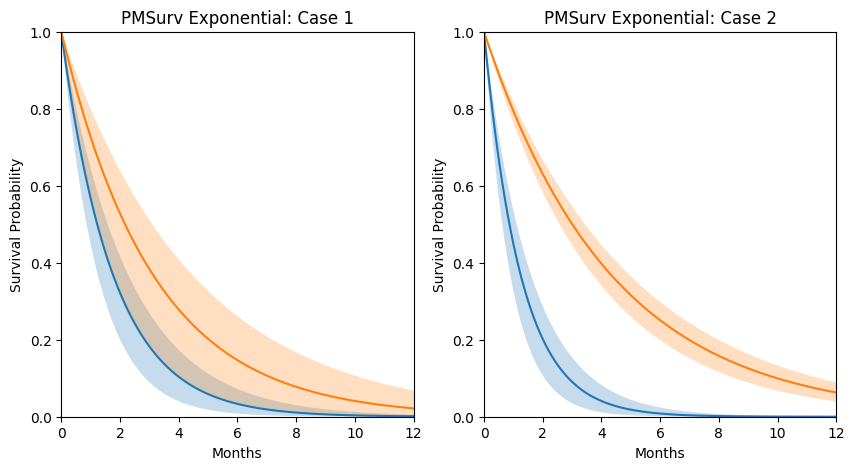

In [159]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Exponential: Case 1");
plt.plot(t_plot_e, surv_e[0]);
plt.fill_between(t_plot_e, y1=surv_e_lower[0], y2=surv_e_upper[0], alpha=0.25);
plt.plot(t_plot_e, surv_e[1]);
plt.fill_between(t_plot_e, y1=surv_e_lower[1], y2=surv_e_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.ylabel("Survival Probability");
plt.xlabel("Months");
plt.xlim(0, 12);

plt.subplot(1, 2, 2)
plt.title("PMSurv Exponential: Case 2");
plt.plot(t_plot_e, surv_e[2]);
plt.fill_between(t_plot_e, y1=surv_e_lower[2], y2=surv_e_upper[2], alpha=0.25);
plt.plot(t_plot_e, surv_e[3]);
plt.fill_between(t_plot_e, y1=surv_e_lower[3], y2=surv_e_upper[3], alpha=0.25);
plt.ylim(0, 1)
plt.ylabel("Survival Probability");
plt.xlabel("Months");
plt.xlim(0, 12);

# Weibull

In [163]:
import pmsurv_weibull

In [160]:
metrics, model_wb, best_params_wb, scaler_wb, _ = train_model_generic(dataset, config, train_kwargs, pmsurv_weibull.preprocess_data, pmsurv_weibull.train_model)

/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

Sampling time =  0:00:09.882711
Transforming variables...
Transformation time =  0:00:00.152521
Computing Log Likelihood...
Log Likelihood time =  0:00:00.502726
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.623702
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.160554
Transforming variables...
Transformation time =  0:00:00.307444
Computing Log Likelihood...
Log Likelihood time =  0:00:00.505762
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.847991
Sampling...
Sampling time =  0:00:09.612693
Transforming variables...
Transformation time =  0:00:00.507861
Computing Log Likelihood...
Log Likelihood time =  0:00:00.611237
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.942343
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.120484
Transforming variables...
Transformation time =  0:00:00.270042
Computing Log Likelihood...
Log Likelihood time =  0:00:01.037748
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.385601
Sampling...
Sampling time =  0:00:10.433404
Transforming variables...
Transformation time =  0:00:00.255975
Computing Log Likelihood...
Log Likelihood time =  0:00:00.443916
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.473831
Sampling...


Running chain 1:  50%|█████     | 1500/3000 [00:09<00:00, 3649.04it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 294.17it/s] 

Running chain 0:  70%|███████   | 2100/3000 [00:10<00:00, 2984.69it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 307.08it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 289.00it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self

Sampling time =  0:00:10.471665
Transforming variables...
Transformation time =  0:00:00.519995
Computing Log Likelihood...
Log Likelihood time =  0:00:01.239703
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.364226
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.052323
Transforming variables...
Transformation time =  0:00:00.643573
Computing Log Likelihood...
Log Likelihood time =  0:00:01.096116
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.852248
Sampling...
Sampling time =  0:00:10.275253
Transforming variables...
Transformation time =  0:00:00.517379
Computing Log Likelihood...
Log Likelihood time =  0:00:01.280916
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.881735
Sampling...
Sampling time =  0:00:10.851927
Transforming variables...
Transformation time =  0:00:00.408710
Computing Log Likelihood...
Log Likelihood time =  0:00:01.012057
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1

Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.663199
Transforming variables...
Transformation time =  0:00:00.585694
Computing Log Likelihood...
Log Likelihood time =  0:00:01.314931
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.051413
Sampling...


Running chain 0:  45%|████▌     | 1350/3000 [00:09<00:00, 3909.38it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 316.44it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 311.25it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Running chain 1:   0%|          | 0/3000 [00:09<?, ?it/s]Sampling: []
INFO:pymc:Sampling: []
Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 289.10it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, r

Sampling time =  0:00:09.533622
Transforming variables...
Transformation time =  0:00:00.365401
Computing Log Likelihood...
Log Likelihood time =  0:00:01.295991
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.422276
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.032110
Transforming variables...
Transformation time =  0:00:00.248782
Computing Log Likelihood...
Log Likelihood time =  0:00:01.324303
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.940361
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:08.758779
Transforming variables...
Transformation time =  0:00:00.391297
Computing Log Likelihood...
Log Likelihood time =  0:00:01.503614
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.382592
Sampling...
Sampling time =  0:00:10.735387
Transforming variables...
Transformation time =  0:00:00.330808
Computing Log Likelihood...
Log Likelihood time =  0:00:00.939696
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.582094
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:09.872254
Transforming variables...
Transformation time =  0:00:00.364710
Computing Log Likelihood...
Log Likelihood time =  0:00:01.221329
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.750344
Sampling...


Running chain 0:  25%|██▌       | 750/3000 [00:14<00:01, 1879.53it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:15<00:00, 197.00it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:15<00:00, 194.92it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The 

Sampling time =  0:00:15.734181
Transforming variables...
Transformation time =  0:00:00.867975
Computing Log Likelihood...
Log Likelihood time =  0:00:01.286265
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.127348
Sampling...
Sampling time =  0:00:15.147860
Transforming variables...
Transformation time =  0:00:01.103875
Computing Log Likelihood...
Log Likelihood time =  0:00:01.427540
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.322846
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.982445
Transforming variables...
Transformation time =  0:00:00.523699
Computing Log Likelihood...
Log Likelihood time =  0:00:00.736863
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.409013
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.671374
Transforming variables...
Transformation time =  0:00:00.548130
Computing Log Likelihood...
Log Likelihood time =  0:00:00.957905
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.750914
Sampling...
Sampling time =  0:00:15.874876
Transforming variables...
Transformation time =  0:00:00.586424
Computing Log Likelihood...
Log Likelihood time =  0:00:00.718778
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.869957
Sampling...


Running chain 0:  55%|█████▌    | 1650/3000 [00:11<00:00, 3950.92it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 246.49it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 244.31it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The

Sampling time =  0:00:12.651107
Transforming variables...
Transformation time =  0:00:00.386227
Computing Log Likelihood...
Log Likelihood time =  0:00:00.747191
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.555571
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.332641
Transforming variables...
Transformation time =  0:00:00.258260
Computing Log Likelihood...
Log Likelihood time =  0:00:01.002881
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.946689
Sampling...
Sampling time =  0:00:12.601331
Transforming variables...
Transformation time =  0:00:00.348292
Computing Log Likelihood...
Log Likelihood time =  0:00:00.845040
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.957210
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.645825
Transforming variables...
Transformation time =  0:00:00.173495
Computing Log Likelihood...
Log Likelihood time =  0:00:00.655650
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.235012
Sampling...
Sampling time =  0:00:12.829759
Transforming variables...
Transformation time =  0:00:00.227494
Computing Log Likelihood...
Log Likelihood time =  0:00:01.474754
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.338835
Sampling...


Running chain 0:  20%|██        | 600/3000 [00:14<00:01, 1598.73it/s] [A

Running chain 1:  35%|███▌      | 1050/3000 [00:14<00:00, 2328.82it/s]

Running chain 0:  40%|████      | 1200/3000 [00:15<00:00, 1821.72it/s]

Running chain 0:  20%|██        | 600/3000 [00:15<00:01, 1261.85it/s]]

Running chain 1: 100%|██████████| 3000/3000 [00:17<00:00, 175.06it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:17<00:00, 175.17it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:17<00:00, 172.85it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior 

Sampling time =  0:00:17.743488
Transforming variables...
Transformation time =  0:00:00.688411
Computing Log Likelihood...
Log Likelihood time =  0:00:01.020953
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.714452
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:17.873549
Transforming variables...
Transformation time =  0:00:00.770618
Computing Log Likelihood...
Log Likelihood time =  0:00:01.458787
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.976595
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:17.627447
Transforming variables...
Transformation time =  0:00:00.950696
Computing Log Likelihood...
Log Likelihood time =  0:00:01.010687
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.342080
Sampling...
Sampling time =  0:00:16.234844
Transforming variables...
Transformation time =  0:00:00.926160
Computing Log Likelihood...
Log Likelihood time =  0:00:01.465423
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.871309
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:16.972690
Transforming variables...
Transformation time =  0:00:01.075413
Computing Log Likelihood...
Log Likelihood time =  0:00:01.115497
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.725455
Sampling...


Running chain 0:  15%|█▌        | 450/3000 [00:11<00:01, 1815.44it/s]

Running chain 0:  25%|██▌       | 750/3000 [00:11<00:01, 2046.11it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 263.05it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 233.56it/s] 

Running chain 0:  80%|████████  | 2400/3000 [00:13<00:00, 3085.11it/s]/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=Fal

Sampling time =  0:00:13.124066
Transforming variables...
Transformation time =  0:00:00.588969
Computing Log Likelihood...
Log Likelihood time =  0:00:00.863057
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.792140
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.964714
Transforming variables...
Transformation time =  0:00:00.335641
Computing Log Likelihood...
Log Likelihood time =  0:00:00.568979
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.734676
Sampling...
Sampling time =  0:00:12.097838
Transforming variables...
Transformation time =  0:00:00.522488
Computing Log Likelihood...
Log Likelihood time =  0:00:00.652515
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.551482
Sampling...
Sampling time =  0:00:12.963172
Transforming variables...
Transformation time =  0:00:00.497981
Computing Log Likelihood...
Log Likelihood time =  0:00:00.841919
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1

Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.278359
Transforming variables...
Transformation time =  0:00:00.552696
Computing Log Likelihood...
Log Likelihood time =  0:00:00.715732
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.850590
Sampling...


Running chain 0:  65%|██████▌   | 1950/3000 [00:11<00:00, 2345.63it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 221.80it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 238.73it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 222.91it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampli

Sampling time =  0:00:13.839968
Transforming variables...
Transformation time =  0:00:00.559091
Computing Log Likelihood...
Log Likelihood time =  0:00:01.004274
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.382131
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.053402
Transforming variables...
Transformation time =  0:00:00.405903
Computing Log Likelihood...
Log Likelihood time =  0:00:01.217401
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.847077
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.017984
Transforming variables...
Transformation time =  0:00:00.576124
Computing Log Likelihood...
Log Likelihood time =  0:00:00.622382
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.142197
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.011830
Transforming variables...
Transformation time =  0:00:00.597665
Computing Log Likelihood...
Log Likelihood time =  0:00:00.714204
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.378583
Sampling...
Sampling time =  0:00:13.690043
Transforming variables...
Transformation time =  0:00:00.726555
Computing Log Likelihood...
Log Likelihood time =  0:00:00.662889
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.948992
Sampling...


Running chain 0:  25%|██▌       | 750/3000 [00:11<00:01, 1915.83it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 235.06it/s] 

Running chain 1:  50%|█████     | 1500/3000 [00:12<00:00, 2470.18it/s]/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Running chain 0:  35%|███▌      | 1050/3000 [00:13<00:01, 1788.93it/s]Sampling: []
INFO:pymc:Sampling: []

Running chain 1:  45%|████▌     | 1350/3000 [00:13<00:00, 1672.72it/s]/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cach

Sampling time =  0:00:13.198869
Transforming variables...
Transformation time =  0:00:00.507405
Computing Log Likelihood...
Log Likelihood time =  0:00:00.874288
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.973708
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.551560
Transforming variables...
Transformation time =  0:00:00.628974
Computing Log Likelihood...
Log Likelihood time =  0:00:00.749845
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.223562
Sampling...
Sampling time =  0:00:13.324771
Transforming variables...
Transformation time =  0:00:00.477185
Computing Log Likelihood...
Log Likelihood time =  0:00:01.061439
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.406513
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.818640
Transforming variables...
Transformation time =  0:00:00.470803
Computing Log Likelihood...
Log Likelihood time =  0:00:00.465031
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.641360
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.127899
Transforming variables...
Transformation time =  0:00:00.667574
Computing Log Likelihood...
Log Likelihood time =  0:00:00.538576
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.113366
Sampling...


Running chain 1:  75%|███████▌  | 2250/3000 [00:13<00:00, 1750.23it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 223.17it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 218.65it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 228.72it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 210.72it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=

Sampling time =  0:00:13.665849
Transforming variables...
Transformation time =  0:00:00.569298
Computing Log Likelihood...
Log Likelihood time =  0:00:00.787932
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.321249
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.782950
Transforming variables...
Transformation time =  0:00:00.408295
Computing Log Likelihood...
Log Likelihood time =  0:00:00.654444
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.656386
Sampling...
Sampling time =  0:00:14.319338
Transforming variables...
Transformation time =  0:00:00.537866
Computing Log Likelihood...
Log Likelihood time =  0:00:00.803160
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.523724
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.946422
Transforming variables...
Transformation time =  0:00:00.619452
Computing Log Likelihood...
Log Likelihood time =  0:00:00.850810
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.988704
Sampling...
Sampling time =  0:00:13.490034
Transforming variables...
Transformation time =  0:00:00.658119
Computing Log Likelihood...
Log Likelihood time =  0:00:01.688365
fitted
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.982371
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 266.24it/s] 

Running chain 0:  75%|███████▌  | 2250/3000 [00:10<00:00, 5276.45it/s]/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,

Running chain 1:  70%|███████   | 2100/3000 [00:10<00:00, 4247.01it/s]Sampling: []
INFO:pymc:Sampling: []
Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 269.43it/s] 

Running chain 0:  60%|██████    | 1800/3000 [00:11<00:00, 4052.99it/s]/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cac

{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:01.428523
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:05.028994
Transforming variables...
Transformation time =  0:00:00.164622
Computing Log Likelihood...


Sampling: []
INFO:pymc:Sampling: []


Log Likelihood time =  0:00:00.608528
fitted
Test metrics: 0.5716463414634146


In [289]:
joblib.dump(model_wb['selector'], 'models/wb/selector.pkl')
joblib.dump(scaler_wb, 'models/wb/scaler.pkl')
model_wb['model'].save('models/wb/model.yaml')

store:  {'k_coefs': False, 'uncertainty': [], 'lambda_mu': 1, 'lambda_sd': 1, 'k_mu': 1, 'k_sd': 1, 'lambda_coefs_mu': 0, 'lambda_coefs_sd': 1, 'k_coefs_mu': 0, 'k_coefs_sd': 1}


In [182]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_wb.transform(X_predict[continuous_features])
surv_wb, surv_wb_lower, surv_wb_upper = model_wb.predict(X_predict)
t_plot_wb = pmsurv.utils.get_time_axis(0, model_wb['model'].max_time, 10) / 30.25

Sampling: []
INFO:pymc:Sampling: []


## Plot

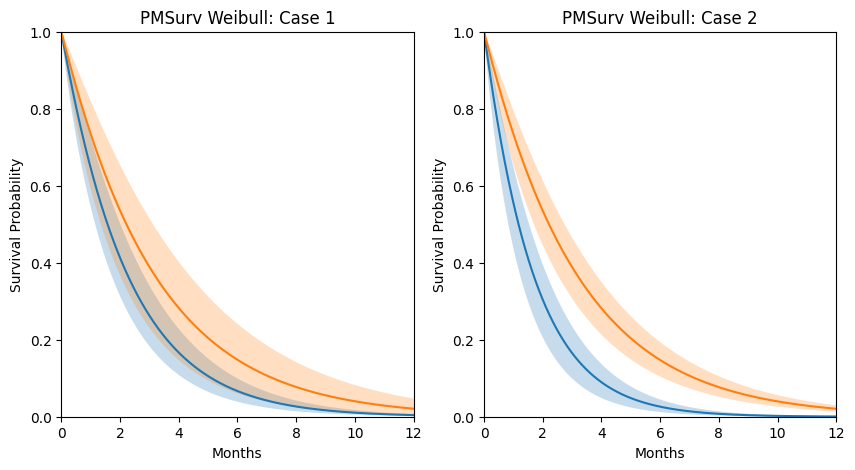

In [184]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Weibull: Case 1");
plt.plot(t_plot_wb, surv_wb[0]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[0], y2=surv_wb_upper[0], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[1]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[1], y2=surv_wb_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("PMSurv Weibull: Case 2");
plt.plot(t_plot_wb, surv_wb[2]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[2], y2=surv_wb_upper[2], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[3]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[3], y2=surv_wb_upper[3], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

# Weibull NN

In [164]:
metrics, model_nn, best_params_nn, scaler_nn, _ = train_model_generic(dataset, config, train_kwargs, pmsurv_weibull_nn.preprocess_data, pmsurv_weibull_nn.train_model)

Sampling time =  0:00:10.825495
Transforming variables...
Transformation time =  0:00:00.829209
Computing Log Likelihood...
Log Likelihood time =  0:00:00.736374
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.281804
Sampling...
Sampling time =  0:00:12.314524
Transforming variables...
Transformation time =  0:00:00.216459
Computing Log Likelihood...
Log Likelihood time =  0:00:00.422987
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.487703
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:11.743307
Transforming variables...
Transformation time =  0:00:00.358357
Computing Log Likelihood...
Log Likelihood time =  0:00:00.678526
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.640129
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:11.670033
Transforming variables...
Transformation time =  0:00:00.363608
Computing Log Likelihood...
Log Likelihood time =  0:00:00.526590
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:02.888433
Sampling...
Sampling time =  0:00:10.898453
Transforming variables...
Transformation time =  0:00:00.335904
Computing Log Likelihood...
Log Likelihood time =  0:00:00.703616
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.004979
Sampling...


Running chain 1:  25%|██▌       | 750/3000 [00:09<00:02, 1032.99it/s]

Running chain 0:  15%|█▌        | 450/3000 [00:10<00:03, 795.69it/s]s]A

Running chain 1:  10%|█         | 300/3000 [00:10<00:03, 776.22it/s]

Running chain 0:  75%|███████▌  | 2250/3000 [00:11<00:01, 743.93it/s]]

Running chain 0:  55%|█████▌    | 1650/3000 [00:12<00:01, 792.17it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 219.05it/s]

Running chain 0:  75%|███████▌  | 2250/3000 [00:13<00:00, 751.24it/s]

Running chain 1:  90%|█████████ | 2700/3000 [00:13<00:00, 1067.59it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 206.26it/s] 
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:13.082688
Transforming variables...
Transformation time =  0:00:01.197020
Computing Log Likelihood...
Log Likelihood time =  0:00:01.764431
fitted
[5, 5]
[5, 5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.905246
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.858188
Transforming variables...
Transformation time =  0:00:00.758099
Computing Log Likelihood...
Log Likelihood time =  0:00:01.173411
fitted
[5, 5]
[5, 5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.892847
Sampling...



Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.260833
Transforming variables...
Transformation time =  0:00:00.882470
Computing Log Likelihood...
Log Likelihood time =  0:00:01.164063
fitted
[5, 5]
[5, 5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.944904
Sampling...
Sampling time =  0:00:15.062825
Transforming variables...
Transformation time =  0:00:00.736972
Computing Log Likelihood...
Log Likelihood time =  0:00:01.070620
fitted
[5, 5]
[5, 5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.579464
Sampling...
Sampling time =  0:00:13.735710
Transforming variables...
Transformation time =  0:00:00.944173
Computing Log Likelihood

Running chain 0:   5%|▌         | 150/3000 [00:13<00:09, 312.48it/s]

Running chain 1:  35%|███▌      | 1050/3000 [00:15<00:05, 372.37it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:21<00:00, 141.61it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:21<00:00, 137.93it/s]
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:21.855134
Transforming variables...
Transformation time =  0:00:00.945736
Computing Log Likelihood...
Log Likelihood time =  0:00:01.988864
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.586564
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:22.100322
Transforming variables...
Transformation time =  0:00:00.785639
Computing Log Likelihood...
Log Likelihood time =  0:00:00.898249
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.961714
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:20.991958
Transforming variables...
Transformation time =  0:00:01.322083
Computing Log Likelihood...
Log Likelihood time =  0:00:01.259885
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.170345
Sampling...
Sampling time =  0:00:21.103809
Transforming variables...
Transformation time =  0:00:01.288868
Computing Log Likelihood...
Log Likelihood time =  0:00:01.951552
fitted
[4]
[4, 4, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.080928
Sampling...
Sampling time =  0:00:22.585746
Transforming variables...
Transformation time =  0:00:01.070357
Computing Log Likelihood...
Log Like

Running chain 1:  10%|█         | 300/3000 [00:13<00:05, 456.28it/s]

Running chain 0:  70%|███████   | 2100/3000 [00:14<00:01, 596.47it/s]

Running chain 1:  50%|█████     | 1500/3000 [00:15<00:02, 663.94it/s]

Running chain 0:  75%|███████▌  | 2250/3000 [00:16<00:01, 617.89it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:15<00:00, 188.92it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:16<00:00, 180.69it/s]
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:17.266785
Transforming variables...
Transformation time =  0:00:00.766974
Computing Log Likelihood...
Log Likelihood time =  0:00:01.167611
fitted
[3, 3]
[3, 3, 3, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.372007
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:16.597459
Transforming variables...
Transformation time =  0:00:00.527947
Computing Log Likelihood...
Log Likelihood time =  0:00:01.186527
fitted
[3, 3]
[3, 3, 3, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.886986
Sampling...
Sampling time =  0:00:17.098645
Transforming variables...
Transformation time =  0:00:00.283851
Computing Log Likelihood...
Log Likelihood time =  0:00:00.726320
fitted
[3, 3]
[3, 3, 3, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:06.036686
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:17.733140
Transforming variables...
Transformation time =  0:00:00.381950
Computing Log Likelihood...
Log Likelihood time =  0:00:00.744449
fitted
[3, 3]
[3, 3, 3, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:06.514251
Sampling...
Sampling time =  0:00:16.970787
Transforming variables...
Transformation time =  0:00:00.567346
Computing Log Likelihood...
Log Likelihood time =  0:00:01.083225
fitted
[3, 3]
[3, 3, 3, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:06.361517
Sampling...


Running chain 1:  55%|█████▌    | 1650/3000 [00:17<00:02, 629.80it/s]

Running chain 1:  45%|████▌     | 1350/3000 [00:17<00:03, 479.31it/s]

Running chain 1:  80%|████████  | 2400/3000 [00:18<00:01, 461.75it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:19<00:00, 155.93it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:20<00:00, 148.83it/s]

Running chain 0:  75%|███████▌  | 2250/3000 [00:19<00:01, 410.91it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:21<00:00, 137.62it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:22<00:00, 132.80it/s]
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:22.749716
Transforming variables...
Transformation time =  0:00:01.228966
Computing Log Likelihood...
Log Likelihood time =  0:00:01.529445
fitted
[7]
[7, 7, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.101490
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:21.244597
Transforming variables...
Transformation time =  0:00:01.599583
Computing Log Likelihood...
Log Likelihood time =  0:00:01.663879
fitted
[7]
[7, 7, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.337242
Sampling...
Sampling time =  0:00:20.409540
Transforming variables...
Transformation time =  0:00:01.746333
Computing Log Likelihood...
Log Likelihood time =  0:00:01.529249
fitted
[7]
[7, 7, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.536861
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:23.739871
Transforming variables...
Transformation time =  0:00:01.082452
Computing Log Likelihood...
Log Likelihood time =  0:00:00.974575
fitted
[7]
[7, 7, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.837297
Sampling...
Sampling time =  0:00:22.825728
Transforming variables...
Transformation time =  0:00:01.295712
Computing Log Likelihood...
Log Likelihood time =  0:00:01.064795
fitted
[7]
[7, 7, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.758113
Sampling...


Running chain 0:  40%|████      | 1200/3000 [00:17<00:04, 391.40it/s][A

Running chain 0:  55%|█████▌    | 1650/3000 [00:18<00:03, 402.03it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:22<00:00, 133.67it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:22<00:00, 134.52it/s]
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:23.178697
Transforming variables...
Transformation time =  0:00:00.814475
Computing Log Likelihood...
Log Likelihood time =  0:00:01.137982
fitted
[6]
[6, 6, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.299467
Sampling...
Sampling time =  0:00:23.100301
Transforming variables...
Transformation time =  0:00:00.639296
Computing Log Likelihood...
Log Likelihood time =  0:00:00.918796
fitted
[6]
[6, 6, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.141737
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:23.366578
Transforming variables...
Transformation time =  0:00:00.635608
Computing Log Likelihood...
Log Likelihood time =  0:00:00.827705
fitted
[6]
[6, 6, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.653761
Sampling...
Sampling time =  0:00:23.070463
Transforming variables...
Transformation time =  0:00:00.905012
Computing Log Likelihood...
Log Likelihood time =  0:00:00.938216
fitted
[6]
[6, 6, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.488157
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:23.397914
Transforming variables...
Transformation time =  0:00:00.753361
Computing Log Likelihood...
Log Likelihood time =  0:00:01.057284
fitted
[6]
[6, 6, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.642778
Sampling...


Running chain 0:  10%|█         | 300/3000 [00:15<00:05, 455.30it/s]

Running chain 0:  15%|█▌        | 450/3000 [00:15<00:05, 449.46it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:21<00:00, 141.04it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:22<00:00, 135.60it/s]
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:22.208460
Transforming variables...
Transformation time =  0:00:01.109438
Computing Log Likelihood...
Log Likelihood time =  0:00:01.004017
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.207394
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:22.810212
Transforming variables...
Transformation time =  0:00:00.762359
Computing Log Likelihood...
Log Likelihood time =  0:00:01.459687
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.592356
Sampling...
Sampling time =  0:00:22.220421
Transforming variables...
Transformation time =  0:00:00.848563
Computing Log Likelihood...
Log Likelihood time =  0:00:01.224430
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.808461
Sampling...
Sampling time =  0:00:23.252647
Transforming variables...
Transformation time =  0:00:00.804938
Computing Log Likelihood...
Log Like

Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:21.872752
Transforming variables...
Transformation time =  0:00:01.164481
Computing Log Likelihood...
Log Likelihood time =  0:00:01.949985
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.047687
Sampling...


Running chain 1:  25%|██▌       | 750/3000 [00:14<00:03, 578.40it/s]

Running chain 0:  45%|████▌     | 1350/3000 [00:15<00:02, 622.69it/s][A

Running chain 0:  50%|█████     | 1500/3000 [00:16<00:02, 566.33it/s]

Running chain 1:  55%|█████▌    | 1650/3000 [00:16<00:02, 547.75it/s]

Running chain 1:  70%|███████   | 2100/3000 [00:17<00:01, 555.05it/s]

Running chain 0:  60%|██████    | 1800/3000 [00:17<00:02, 571.67it/s]

Running chain 0:  75%|███████▌  | 2250/3000 [00:17<00:01, 589.99it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:18<00:00, 158.93it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:18<00:00, 157.96it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:19<00:00, 156.17it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:18<00:00, 159.25it/s]
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:19.505286
Transforming variables...
Transformation time =  0:00:00.260404
Computing Log Likelihood...
Log Likelihood time =  0:00:01.014252
fitted
[1, 1]
[1, 1, 1, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.939214
Sampling...
Sampling time =  0:00:19.611280
Transforming variables...
Transformation time =  0:00:00.380449
Computing Log Likelihood...
Log Likelihood time =  0:00:00.710482
fitted
[1, 1]
[1, 1, 1, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.968062
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:19.739120
Transforming variables...
Transformation time =  0:00:00.339168
Computing Log Likelihood...
Log Likelihood time =  0:00:00.815706
fitted
[1, 1]
[1, 1, 1, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:06.300342
Sampling...
Sampling time =  0:00:19.845709
Transforming variables...
Transformation time =  0:00:00.316154
Computing Log Likelihood...
Log Likelihood time =  0:00:00.725237
fitted
[1, 1]
[1, 1, 1, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:06.328216
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:19.489092
Transforming variables...
Transformation time =  0:00:00.461767
Computing Log Likelihood...
Log Likelihood time =  0:00:00.718901
fitted
[1, 1]
[1, 1, 1, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:05.768609
Sampling...


Running chain 1:  35%|███▌      | 1050/3000 [00:12<00:00, 2209.15it/s]

Running chain 1:  20%|██        | 600/3000 [00:13<00:01, 1216.01it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 209.66it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 202.41it/s] 
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:14.746723
Transforming variables...
Transformation time =  0:00:00.840209
Computing Log Likelihood...
Log Likelihood time =  0:00:00.763047
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.511691
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.043869
Transforming variables...
Transformation time =  0:00:00.721094
Computing Log Likelihood...
Log Likelihood time =  0:00:00.830973
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.771850
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.633694
Transforming variables...
Transformation time =  0:00:00.588641
Computing Log Likelihood...
Log Likelihood time =  0:00:00.700090
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.095370
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.359314
Transforming variables...
Transformation time =  0:00:00.951883
Computing Log Likelihood...
Log Likelihood time =  0:00:00.810173
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.346591
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.479648
Transforming variables...
Transformation time =  0:00:00.717932
Computing Log Likelihood...
Log Likelihood time =  0:00:00.737089
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:04.837669
Sampling...


Running chain 0:  25%|██▌       | 750/3000 [00:13<00:04, 491.74it/s]]

Running chain 0:  60%|██████    | 1800/3000 [00:14<00:02, 588.57it/s]

Running chain 0:  50%|█████     | 1500/3000 [00:14<00:02, 585.83it/s]

Running chain 0:  60%|██████    | 1800/3000 [00:15<00:01, 636.28it/s]

Running chain 0:  80%|████████  | 2400/3000 [00:16<00:00, 622.86it/s]

Running chain 0:  95%|█████████▌| 2850/3000 [00:15<00:00, 660.66it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:17<00:00, 172.74it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:17<00:00, 173.98it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:18<00:00, 163.46it/s]
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


Sampling time =  0:00:18.000412
Transforming variables...
Transformation time =  0:00:00.421021
Computing Log Likelihood...
Log Likelihood time =  0:00:00.767312
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.221704
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:17.947309
Transforming variables...
Transformation time =  0:00:00.461868
Computing Log Likelihood...
Log Likelihood time =  0:00:00.759078
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.477215
Sampling...
Sampling time =  0:00:17.139452
Transforming variables...
Transformation time =  0:00:00.706990
Computing Log Likelihood...
Log Likelihood time =  0:00:00.968193
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.490837
Sampling...
Sampling time =  0:00:17.849147
Transforming variables...
Transformation time =  0:00:00.337083
Computing Log Likelihood...
Log Like

Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:18.906900
Transforming variables...
Transformation time =  0:00:00.537250
Computing Log Likelihood...
Log Likelihood time =  0:00:00.630594
fitted
[5]
[5, 5, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.776051
Sampling...


Running chain 0:  35%|███▌      | 1050/3000 [00:17<00:05, 337.75it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:19<00:00, 152.92it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:22<00:00, 131.30it/s]


Running chain 1: 100%|██████████| 3000/3000 [00:22<00:00, 131.91it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:23<00:00, 128.41it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:23<00:00, 127.18it/s]
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []


[6]
[6, 6, 2]
create cached with real data
With k False
{'draws': 2000, 'tune': 1000, 'target_accept': 0.8, 'chains': 2, 'cores': 1, 'return_inferencedata': True, 'progressbar': False, 'type': 'blackjax'}
Compiling...
Compilation time =  0:00:03.696067
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:09.142039
Transforming variables...
Transformation time =  0:00:00.167415
Computing Log Likelihood...


Sampling: []
INFO:pymc:Sampling: []


Log Likelihood time =  0:00:00.518259
fitted
Test metrics: 0.6781914893617021
Sampling time =  0:00:20.043351
Transforming variables...
Transformation time =  0:00:01.413779
Computing Log Likelihood...
Log Likelihood time =  0:00:02.918504
fitted
Sampling time =  0:00:23.463700
Transforming variables...
Transformation time =  0:00:00.937690
Computing Log Likelihood...
Log Likelihood time =  0:00:01.213861
fitted
Sampling time =  0:00:23.526766
Transforming variables...
Transformation time =  0:00:00.686259
Computing Log Likelihood...
Log Likelihood time =  0:00:00.897262
fitted
Sampling time =  0:00:23.916464
Transforming variables...
Transformation time =  0:00:00.614313
Computing Log Likelihood...
Log Likelihood time =  0:00:00.841255
fitted
Sampling time =  0:00:24.337378
Transforming variables...
Transformation time =  0:00:00.507764
Computing Log Likelihood...
Log Likelihood time =  0:00:00.871496
fitted


In [290]:
joblib.dump(model_nn['selector'], 'models/nn/selector.pkl')
joblib.dump(scaler_nn, 'models/nn/scaler.pkl')
model_nn['model'].save('models/nn/model.yaml')

In [165]:
print(f"score {metrics:0.3f}")

score 0.678


In [166]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_nn.transform(X_predict[continuous_features])
surv_nn, surv_nn_lower, surv_nn_upper = model_nn.predict(X_predict)
t_plot = pmsurv.utils.get_time_axis(0, model_nn['model'].max_time, 10) / 30.25

Sampling: []
INFO:pymc:Sampling: []


## Plot

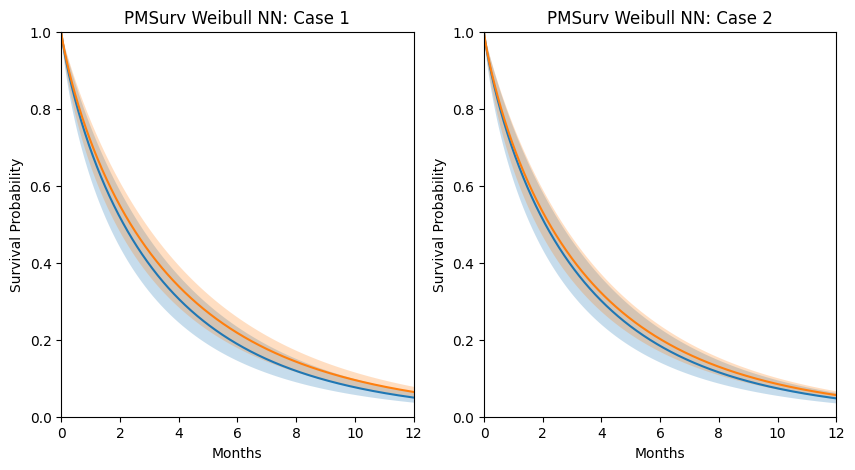

In [168]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Weibull NN: Case 1");
plt.plot(t_plot, surv_nn[0]);
plt.fill_between(t_plot, y1=surv_nn_lower[0], y2=surv_nn_upper[0], alpha=0.25);
plt.plot(t_plot, surv_nn[1]);
plt.fill_between(t_plot, y1=surv_nn_lower[1], y2=surv_nn_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("PMSurv Weibull NN: Case 2");
plt.plot(t_plot, surv_nn[2]);
plt.fill_between(t_plot, y1=surv_nn_lower[2], y2=surv_nn_upper[2], alpha=0.25);
plt.plot(t_plot, surv_nn[3]);
plt.fill_between(t_plot, y1=surv_nn_lower[3], y2=surv_nn_upper[3], alpha=0.25);
plt.ylim(0, 1)
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

# Cox PH

In [169]:
import coxph

In [170]:
metrics, model_cox, best_params_cox, scaler_cox, _ = train_model_generic(dataset, config, train_kwargs, coxph.preprocess_data, coxph.train_model)

Test metrics: 0.6728723404255319


In [292]:
joblib.dump(model_cox, 'models/cox/model.pkl')
joblib.dump(scaler_cox, 'models/cox/scaler.pkl')

['models/cox/scaler.pkl']

In [171]:
print(f"Score = {metrics:0.3f}");

Score = 0.673


In [173]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_cox.transform(X_predict[continuous_features])
surv_cox_ = model_cox.predict_survival_function(X_predict)
t_plot_cox = [surv_cox_[0].x, surv_cox_[1].x, surv_cox_[2].x, surv_cox_[3].x]
surv_cox = [surv_cox_[0].y, surv_cox_[1].y, surv_cox_[2].y, surv_cox_[3].y]

# DeepSurv

In [188]:
import deepsurv

In [ ]:
metrics, model_dp, best_params_dp, scaler_dp, _ = train_model_generic(dataset, config, train_kwargs, deepsurv.preprocess_data, deepsurv.train_model)

In [294]:
joblib.dump(model_dp, 'models/dp/model.pkl')
joblib.dump(scaler_dp, 'models/dp/scaler.pkl')

['models/dp/scaler.pkl']

In [ ]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_cox.transform(X_predict[continuous_features])
surv = model_dp.predict(X_predict)
t_plot_dp = np.linspace(0, 1, surv[0].shape[0]) * max(y[:, 0]) / 30.25
surv_dp = surv

In [190]:
from deepsurv import PyCoxWrapper
import numpy as np

In [191]:
X, y = deepsurv.preprocess_data(dataset, config)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=config['split']['test_size'],
                                                    shuffle=config['split']['shuffle'],
                                                   random_state=SEED)

scaler_dp = StandardScaler()
X_train[continuous_features] = scaler_dp.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler_dp.transform(X_test[continuous_features])

In [198]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [219]:
model_dp = PyCoxWrapper(hidden_units=1)
model_dp.fit(X_train.values, y_train);

In [220]:
score = model_dp.score(X_test, y_test);
print(f"Score = {score:0.3f}")

Score = 0.644


In [221]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_dp.transform(X_predict[continuous_features])
surv = model_dp.predict(X_predict)
t_plot_dp = np.linspace(0, 1, surv[0].shape[0]) * max(y[:, 0]) / 30.25
surv_dp = surv

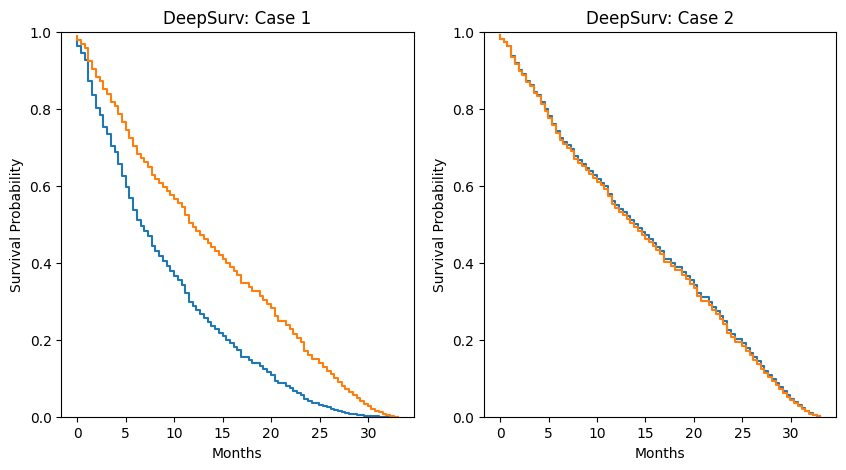

In [222]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("DeepSurv: Case 1");
plt.step(t_plot_dp, surv_dp[0]);
plt.step(t_plot_dp, surv_dp[1]);
plt.ylim(0, 1);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("DeepSurv: Case 2");
plt.step(t_plot_dp, surv_dp[2]);
plt.step(t_plot_dp, surv_dp[3]);
plt.ylim(0, 1)
plt.ylabel("Survival Probability");
plt.xlabel("Months");

# RSF

In [174]:
import rsf

In [175]:
metrics, model_rsf, best_params_rsf, scaler_rsf, _ = train_model_generic(dataset, config, train_kwargs, rsf.preprocess_data, rsf.train_model)

Test metrics: 0.604225352112676


In [295]:
joblib.dump(model_rsf, 'models/rsf/model.pkl')
joblib.dump(scaler_rsf, 'models/rsf/scaler.pkl')

['models/rsf/scaler.pkl']

In [298]:
model_rsf = joblib.load('models/rsf/model.pkl')
scaler_rsf = joblib.load('models/rsf/scaler.pkl')

In [299]:
print(f"Score = {metrics:0.3f}")

Score = 0.604


In [300]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_cox.transform(X_predict[continuous_features])
surv = model_rsf.predict_survival_function(X_predict)
t_plot_rsf = [surv[0].x, surv[1].x, surv[2].x, surv[3].x]
surv_rsf = [surv[0].y, surv[1].y, surv[2].y, surv[3].y]

# Plots

In [180]:
def plot_surv(model_name, case, t_plot, surv, surv_upper, surv_lower, i1, i2, step=False):
    plt.title(f"{model_name}: {case}");
    
    if step:
        plt.step(t_plot, surv[i1]);
    else:
        plt.plot(t_plot, surv[i1]);
    
    if surv_lower is not None:
        plt.fill_between(t_plot, y1=surv_lower[i1], y2=surv_upper[i1], alpha=0.25);
    
    if step:
        plt.step(t_plot, surv[i2]);
    else:
        plt.plot(t_plot, surv[i2]);
    
    if surv_lower is not None:
        plt.fill_between(t_plot, y1=surv_lower[i2], y2=surv_upper[i2], alpha=0.25);
    
    plt.ylim(0, 1);
    plt.ylabel("Survival Probability");
    plt.xlabel("Months");
    plt.xlim(0, 12);


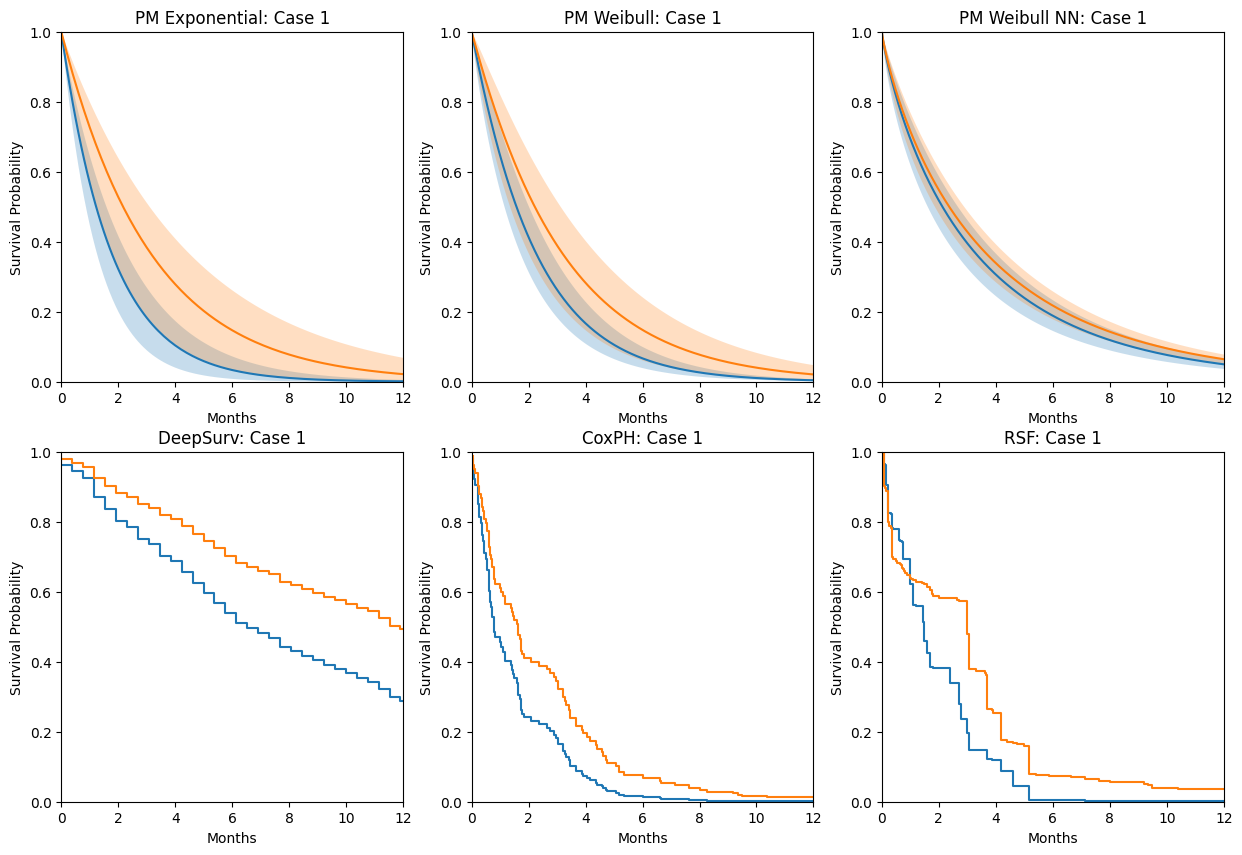

In [301]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1);
plot_surv("PM Exponential", "Case 1", t_plot_e, surv_e, surv_e_upper, surv_e_lower, 0, 1);
plt.subplot(2, 3, 2);
plot_surv("PM Weibull", "Case 1", t_plot_wb, surv_wb, surv_wb_upper, surv_wb_lower, 0, 1);
plt.subplot(2, 3, 3);
plot_surv("PM Weibull NN", "Case 1", t_plot, surv_nn, surv_nn_upper, surv_nn_lower, 0, 1);

plt.subplot(2, 3, 4);
plot_surv("DeepSurv", "Case 1", t_plot_dp, surv_dp, None, None, 0, 1, step=True);
plt.subplot(2, 3, 5);
plot_surv("CoxPH", "Case 1", t_plot_cox[0]/30.25, surv_cox, None, None, 0, 1, step=True);
plt.subplot(2, 3, 6);
plot_surv("RSF", "Case 1", t_plot_rsf[0]/30.25, surv_rsf, None, None, 0, 1, step=True);

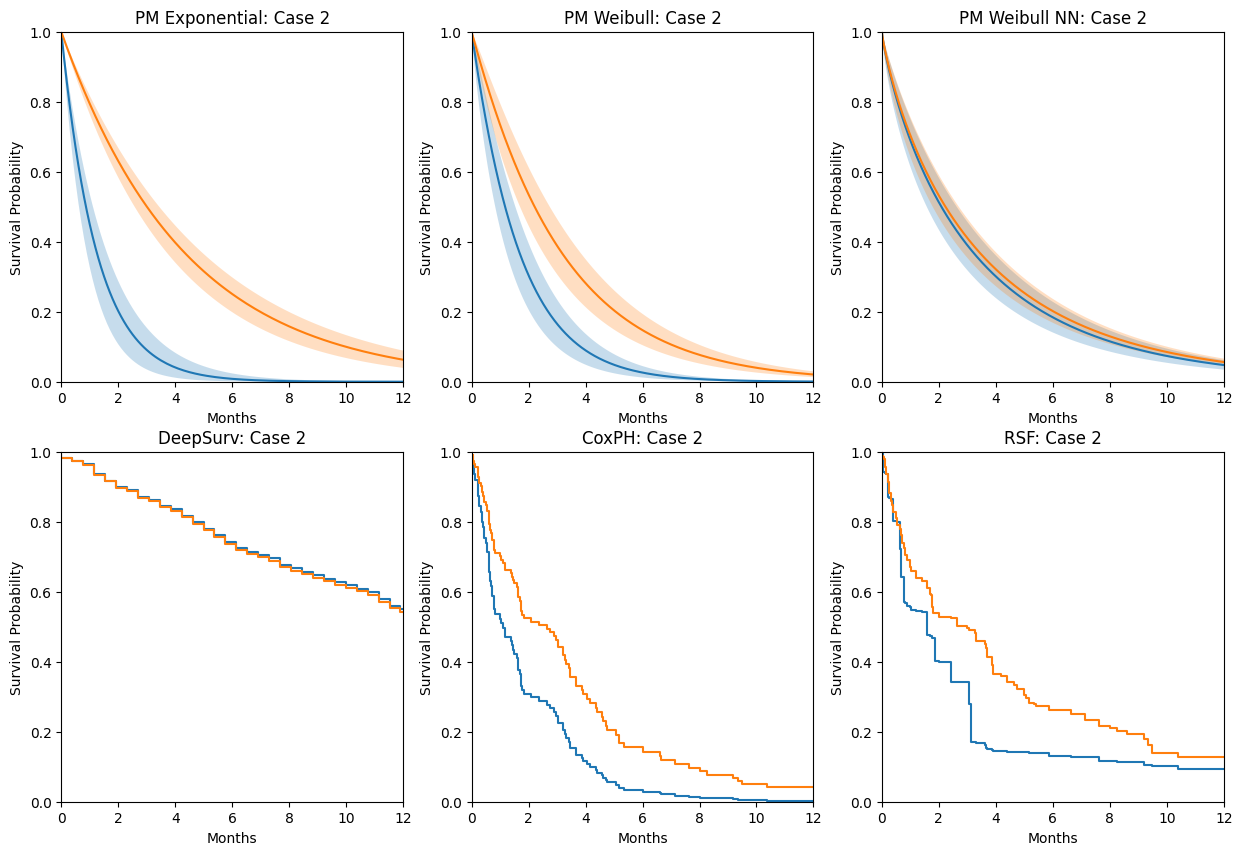

In [302]:
plt.figure(figsize=(15, 10))
idx_1, idx_2 = 2, 3
plt.subplot(2, 3, 1)
plot_surv("PM Exponential", "Case 2", t_plot_e, surv_e, surv_e_upper, surv_e_lower, idx_1, idx_2);
plt.subplot(2, 3, 2)
plot_surv("PM Weibull", "Case 2", t_plot_wb, surv_wb, surv_wb_upper, surv_wb_lower, idx_1, idx_2);
plt.subplot(2, 3, 3)
plot_surv("PM Weibull NN", "Case 2", t_plot, surv_nn, surv_nn_upper, surv_nn_lower, idx_1, idx_2);

plt.subplot(2, 3, 4)
plot_surv("DeepSurv", "Case 2", t_plot_dp, surv_dp, None, None, idx_1, idx_2, step=True);
plt.subplot(2, 3, 5)
plot_surv("CoxPH", "Case 2", t_plot_cox[0]/30.25, surv_cox, None, None, idx_1, idx_2, step=True);
plt.subplot(2, 3, 6)
plot_surv("RSF", "Case 2", t_plot_rsf[0]/30.25, surv_rsf, None, None, idx_1, idx_2, step=True);

# Compare

In [227]:
from lifelines import KaplanMeierFitter

<AxesSubplot: xlabel='timeline'>

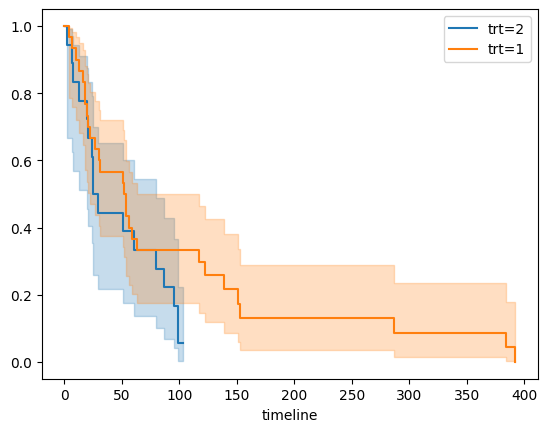

In [233]:
idx_trt = (dataset['trt_2'] == 1) & (dataset['celltype_2'] == 1)
kmf1 = KaplanMeierFitter(label="trt=2")
kmf1.fit(dataset[idx_trt]['time'], dataset[idx_trt]['status'])
kmf1.plot()

idx_trt = (dataset['trt_2'] == 0) & (dataset['celltype_2'] == 1)
kmf2 = KaplanMeierFitter(label="trt=1")
kmf2.fit(dataset[idx_trt]['time'], dataset[idx_trt]['status'])
kmf2.plot()

<AxesSubplot: xlabel='timeline'>

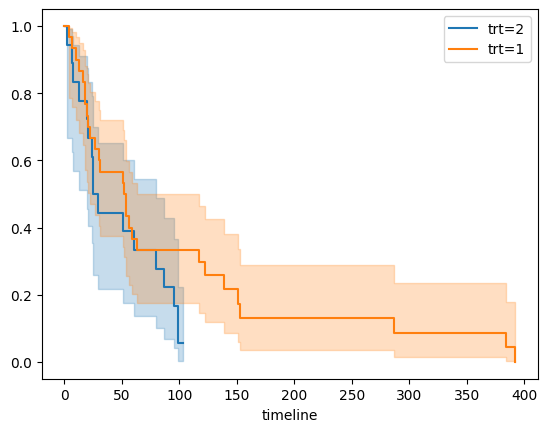

In [236]:
idx_trt = (dataset['trt_2'] == 1) & (dataset['celltype_2'] == 1)
kmf1 = KaplanMeierFitter(label="trt=2")
kmf1.fit(dataset[idx_trt]['time'], dataset[idx_trt]['status'])
kmf1.plot()

idx_trt = (dataset['trt_2'] == 0) & (dataset['celltype_2'] == 1)
kmf2 = KaplanMeierFitter(label="trt=1")
kmf2.fit(dataset[idx_trt]['time'], dataset[idx_trt]['status'])
kmf2.plot()

In [266]:
case_real_surv = dict()

In [272]:
case_real_surv['Case2_trt'] = dataset[(dataset['trt_2'] == 1) & (dataset['celltype_2'] == 1) & (dataset['age'] >= 62) & (dataset['age'] < 67)]['age'].median()

In [273]:
case_real_surv['Case2_notrt'] = dataset[(dataset['trt_2'] == 0) & (dataset['celltype_2'] == 1) & (dataset['age'] >= 62) & (dataset['age'] < 67)]['age'].median()

In [274]:
case_real_surv['Case1_trt'] = dataset[(dataset['trt_2'] == 1) & (dataset['celltype_3'] == 1) & (dataset['age'] >= 48) & (dataset['age'] < 52)]['age'].median()

In [275]:
case_real_surv['Case1_notrt'] = dataset[(dataset['trt_2'] == 0) & (dataset['celltype_3'] == 1) & (dataset['age'] >= 48) & (dataset['age'] < 52)]['age'].median()

In [276]:
case_real_surv

{'Case2_trt': 62.0,
 'Case2_notrt': 64.5,
 'Case1_trt': 50.0,
 'Case1_notrt': 50.0}